# CHAPTER 20 - Learning Probabilistic Models

### George Tzanetakis, University of Victoria 


## WORKPLAN 

The section number is based on the 4th edition of the AIMA textbook and is the suggested
reading for this week. Each list entry provides just the additional sections. For example the Expected reading include the sections listed under Basic as well as the sections listed under Expected. Some additional readings are suggested for Advanced. 

1. Basic: Sections **20.1**, **20.2.1**, **20.2.2**, and **Summary**
2. Expected: Same as Basic plus **20.3**, **20.3.1**, **20.3.3**
3. Advanced: All the chapter including bibligraphical and historical notes 


We have covered a variety of probabilistic models that model uncertainty and allow us to do inference in different ways. In this notebook we describe some of the ways we can estimate probabistic modesl from data. 
These techniques provide the connection between statistics, probability, and machine learning. 

The ideas are based on Chapter 20 of the Artificial Intelligence: a Modern Approach textbook and specifically section 20.2 Learning from Complete Data. 

**Density estimation** refers to the task of learning the probabiity density function (for continuous models) or the probability distribution function (for discrete models) given some data that we assume was generated from that modal. **Complete data** means that we have data for all the **variables** in our model. 

The most common type of learning is **parameter learning** where we assume a particular structure for our model and characterize it by estimating a set of parameters. For example we might assume a normal or Gaussian multi-variate distribution and estimate the mean vector and the covariance matrix that characterize it. As another example, we might be given the structure of a Bayesian network (in terms of parent/child coonditional relationships) and learn the conditional probabilty tables. We will also briefly discuss the problem of learning structure as well as non-parametric density estimation in which we don't need to make any assumptions about the model. 



# Learning with Complete Data 

## A random variable class 

Define a helper random variable class based on the scipy discrete random variable functionality providing both numeric and symbolic RVs. You don't need to look at the implementation - the usage will be obvious through the examples below. 


In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np 


class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution  
        if all(issubclass(type(item), np.integer) for item in values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'): 
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def probs(self): 
        return self.probability_distribution
    
    def vals(self): 
        print(self.type)
        return self.values 
    
    def prob_of_value(self, value): 
        indices = np.where(self.values == value)
        return self.probability_distribution[indices[0][0]]


            

# Likelihood of model given some data 

First let's review the concept of likelihood of a model given some data 


Lets start by creating a random variable corresponding to a 6-faced dice where there are two faces with the numbers 1,2 and 3 therefore each number appears with equal probability. We can generate random samples from this model. 

In [13]:
import numpy as np
values = np.array([1, 2, 3])
probabilities = [2/6., 2/6., 2/6.]
dice1 = Random_Variable('dice1', values, probabilities)
samples = dice1.sample(30)
print(samples)

[1 1 3 3 2 2 3 2 2 2 3 1 2 3 3 2 1 3 3 2 2 1 1 1 2 1 1 2 2 1]


Lets also create a random variable where three of the faces have the number 2, 2 faces have the number 1 and 1 face has the number 3. We can also generate random samples from this model.

In [14]:
values = np.int_([1, 2, 3])
probabilities = [2./6, 3./6, 1./6]
dice2 = Random_Variable('dice2', values, probabilities)
samples = dice2.sample(30)
print(samples)

[2 1 2 3 2 1 3 2 2 1 2 1 3 3 2 2 2 2 1 3 3 1 1 1 2 2 2 1 2 2]


The likelihood of a sequence of samples given a model can be obtained by taking the product of the corresponding 
probabilities. We can see that for this particular sequence of data the likelihood of the model for dice2 is higher. So if we have some data and some specific models we can select the model with the highest likelihood. 

In [15]:
data = [1,2,2,1,1,3,1,2,3,2]
print(dice1.prob_of_value(1))
print(dice1.prob_of_value(3))
print(dice2.prob_of_value(3))

def likelihood(data, model):
    likelihood = 1.0 
    for d in data: 
        likelihood *= model.prob_of_value(d)
    return likelihood 
    
print("Likelihood for dice1: %f" % likelihood(data,dice1))
print("Likelihood for dice2: %f" % likelihood(data,dice2))


0.3333333333333333
0.3333333333333333
0.16666666666666666
Likelihood for dice1: 0.000017
Likelihood for dice2: 0.000021


Notice that even with only 10 values the likelihood gets relatively small and we can expect it will get smaller as the sequences of data get smaller. We can also use log-likelihood to avoid this problem.

In [16]:
data = [1,2,2,1,1,3,1,2,3,2]
print(dice1.prob_of_value(1))
print(dice1.prob_of_value(3))
print(dice2.prob_of_value(3))

def log_likelihood(data, model):
    likelihood = 0.0 
    for d in data: 
        likelihood += np.log(model.prob_of_value(d))
    return likelihood 
    
print("Likelihood for dice1: %f" % log_likelihood(data,dice1))
print("Likelihood for dice2: %f" % log_likelihood(data,dice2))


0.3333333333333333
0.3333333333333333
0.16666666666666666
Likelihood for dice1: -10.986123
Likelihood for dice2: -10.750557


In the case above we examined two possible models. One could ask the question of all possible models for a particular problem can we find the one with the highest likelihood ? If we have a dice with six faces that can only have the number 1, 2, and 3 then there is a finite amount of models and we can calculate their likelihoods as we did above. However if we relax the requirement to have a dice and simply have the values 1,2 and 3 but with arbitrary associated probabilities then we have an infinte number of possible models. Without going into the math it turns out that at least for this particular case the model that will have the maximum likelihood can be simply obtained by counting the relative frequencies of the values in the data. This is called maximum likelihood estimation of model parameters.

In [17]:
import collections 

data = [1,2,2,1,1,3,1,2,3,2,2,2,2]
counts = collections.Counter(data)
print(counts)
est_probability_distribution = [counts[1]/float(len(data)), counts[2]/float(len(data)), counts[3]/float(len(data))]
print(est_probability_distribution)

Counter({2: 7, 1: 4, 3: 2})
[0.3076923076923077, 0.5384615384615384, 0.15384615384615385]


In [18]:
values = np.int_([1, 2, 3])
probabilities = est_probability_distribution 
model = Random_Variable('model', values, probabilities)
samples = model.sample(30)
print(samples)

[2 1 3 2 1 1 2 1 2 2 2 2 2 2 2 1 3 2 2 2 2 1 3 2 2 1 2 2 3 2]


# Maximum-likelihood parameter learning for Discrete Models  


Lets start by creating a random variable corresponding to a bag of candy with two types lime and cherry similar to what we did in the previous notebook.  We can easily generate random samples from this model. For example in the code below we geenerate 100 samples. 

In [19]:
values = ['c', 'l']
probabilities = [0.2, 0.8]
dice1 = Random_Variable('bag1', values, probabilities)
samples = dice1.sample(100)
print(samples)

['l', 'l', 'l', 'l', 'l', 'l', 'c', 'c', 'l', 'l', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'c', 'l', 'l', 'c', 'l', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'c', 'l', 'c', 'l', 'l', 'l', 'l', 'c', 'c', 'l', 'l', 'l', 'l', 'c', 'l', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'c', 'c', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'c', 'l']


Now imagine that you are just given these samples and you are told that they were from a bag of candy but you don't know the percentage of each candy type in the bag and you need to estimate it. Let's call the probability a candy from the bag is cherry $\theta$. Then our task of parameter learning is to estimate $\theta$ from the provided samples. In the previous notebook without much explanation I stated that the "best" possible model in a maximum likelihood sense can be easily obtained by simply counting the percentage of each candy type in our bag. 
As you can see the estimated paremeter $\theta$ is close but not the same as the original value which was $0.2$. If we had more samples this estimate becomes more accurate.  

We can see that with this simple example we have the ability to "learn" a model. Once we have a "learned" model from the data we can use it to make predictions or inference in general as well as generate samples if needed. 


In [20]:
import collections 

counts = collections.Counter(samples)
print(counts)
est_probability_distribution = [counts['c']/float(len(samples)), counts['l']/float(len(samples))]
print(est_probability_distribution)

Counter({'l': 81, 'c': 19})
[0.19, 0.81]


Using the counts seems intuitive and I told you that for the case of discrete random variables this provides the maximum likelihood estimate but can we prove this assertion? 

Here is how we can do it. Each time we have a candy of a particular type we multiply the associated probability top get the likelihood of the sequence (assuming i.i.d. samples). If there are $c$ cherry candies and $l=N-c$ limes then we can write the likelihood as follows: 

$$ P({\bf d} | h_{\theta}) = \prod_{j=1}^{N} P(d_j | h_{\theta}) = \theta^{c} * (1-\theta)^{l}$$

Note: check how the mathematical expression above is notated. It is using LaTeX notation which can be embedded in markdown cells. It is a useful thing to learn to produce nice looking equations in both notebook and papers. 

The maximum-likelihood hypothesis is given by the value of $\theta$ that maximizes the exression above. The same value can be obtained by maximizing the **log likelihood**. Note that we have used log-likelihood before to avoid small numerical likelihood values when computing over long sequences. Here we use it because it allows us to simplify our expression to prove our approach to maximum likelihood parameter estimation. By taking the log we convert the product to a sum which is easer to maximize. 

$$ L({\bf d}| h_{\theta}) = \log{P({\bf d} | h_{\theta})} = \sum_{j=1}^{N}\log{P(d_j| h_{\theta})} = c \log{ \theta} + l \log{(1-\theta)} $$



To find the maximum-likelihood value of $\theta$, we differentiate the $L$ with respect to $\theta$ and se the resulting expression to zero: 

$$ 
\frac{L({\bf d} / h_{\theta})}{d \theta} = \frac{c}{\theta} - \frac{l}{1-\theta} = 0 
$$

Solving for $\theta$ we get: 
$$ 
\theta = \frac{c}{c+l} = \frac{c}{N}
$$ 

This might seem like a lot of work to prove something obvious but now we actually know that of all the infinite possible models of bags we could have - the one we estimate by counting the proportion of candy is the "best" in a maximum likelihood sense. 


The approach we followed can be used for a variety of probabilistic models. The steps are as follows: 

1. Write down an expression for the likelihood of the data as a function of the parameters and use log to simplify it for step 2 
2. Write down the derivative of the log likelihood with respect to each parameter 
3. Find the parameter values such that the derivatives are zero. 

Note: If we are lucky we are able to perform steps 2 and 3 analytically and derive an exact ML parameter estimate. There are many cases especially when dealing with continuous models (which we cover below) in which 
maximimizing the likelihood function analytically is not possible and one needs to resort to numerical methods 
which do not provide an exact solution. 

As another example of analytical ML parameter estimation, the book has one more example in which there is an extra random variable wrapper and the model has three parameters $\theta_1, \theta_2, \theta_3$. 

For example by basicallly filtering the data and counting we can do ML parameter estimation for Naive Bayes models as well as Baysian Networks with discrete random variables. You have already seen to some extent how this can be done during lectures as well as in the assignments. Notice that the structure of the Bayesian network allows us to simplify the problem of ML parameter estimation by factoring different groups of variables based on their conditional structural relationships. 


# Maximum-Likelihood parameter learning for continuous models 


Continuous probability models are heavily used in real-world applications. Like I mentioned in the previous video - in many cases we need to resort to numerical optimization methods to perform parameter estimatino. However in some cases we can get the exact answer analytically. Let's consider the simple example of learning the parameters of a Gaussian density function on a single variable. Similarly to what we did in the previous video for learning the parameters of a disrete random variable we will first generate some data and then estimate the parameters from the data. 


The data will be generated using a Gaussian density function on a single variable. The corresponding equation is: 

$$ P(x) = \frac{1}{\sqrt{2 \pi \sigma}} e^{-\frac{x-\mu}{2\sigma^2}}$$

The parameters of this model are the mean $\mu$ and the standard deviation $\sigma$. 

In [21]:
mu = 3.0 
sigma = 0.2 
s = np.random.normal(mu, sigma, 10)
print(s)

[2.90383961 3.11383124 2.74047631 2.81324639 2.85427437 2.83708547
 3.27187123 2.75284102 3.29324794 3.17367798]


In [22]:
samples = np.random.normal(mu, sigma, 10000)

Let the observed values by $x_1, \dots, x_N$. Then the log-likelihood is: 

$$ 
L = \sum_{j=1}^{N} \log{\frac{1}{\sqrt{2 \pi \sigma}}} e^{-\frac{x-\mu}{2\sigma^2}} = N(-\log \sqrt{2\pi} - \log \sigma) - \sum_{j=1}^{N} \frac{x-\mu}{2\sigma^2}
$$

Setting the derivatives to zero we obtain: 

$$ 
\frac{\partial L}{\partial \mu} = - \frac{1}{\sigma^2}\sum_{j=1}^{N} (x_j-\mu) = 0 
$$
which implies: 
$$ 
\mu = \frac{\sum_j x_k}{N}
$$

So the maximum likelihood value of the mean is the sample average. Similarly you can find that the maximum likelihood value of the standard deviation is the square root of the sample variance. You can check the textbook for the details of the standard deviation $\sigma$. 

Let's check how we can calculate these ML parameter estimates for the data that we have. 


In [23]:
estimated_mean1 = np.sum(samples) / len(samples)
print(estimated_mean1)
estimated_mean2 = np.mean(samples)
print(estimated_mean2)
estimated_std = np.std(samples)
print(estimated_std)

2.9967265838293855
2.9967265838293855
0.19763576241858616


So armed with simple filtering, counting and calculating sample mean and sample standard deviation we have everything we need to estimate the probabilities of a Naive Bayes model that contains a mixture of continuous and discrete variables. For the discrete variables we count and estimate directly the probabilities. For the continuous variables, we first estimate the ML parameters (sample mean and standard deviation) and then for a particular value of the feature we use the single varaible Gaussian density equation to derive a probability value for that value. 

Some notes for further reading - not needed for the "final" assignment for those interested in digging deeper. 

**Note1**: In a Baysian network with continuous variables you have the problem of having continuous parent and a continuous child variable. These can be addressed with linear Gaussian models. More details in the textbook 

**Note2**: Similarly to Baysian learning in discrete models one can follow a similar approach and use a hypothesis prior to guide the learning. The textbook shows an example that use **beta distributions** you can check out. 

**Note3**: If you remember when we covered Baysian network we looked at approximate inference using direct sampling and rejection sampling. You will notice that the approach we followed was similar to statistical learning in the sense that we generated samples and then used counting to estimate probabilities. So at a basic level inference and learning can be considered the same process. We start with a few things that we know and then using data we update what we know. 

**Note4**: It is also possible to learn the structure of a Bayesian network from data. The basic idea is to search over the space of possible model. To do so we will need some method to determine when a good structure has been found. More details can be found in the book. 


# Bayesian Learning

The two important terms we will cover are data and hypotheses or models. The hypotheses are different probabilistic theories. Let's consider the example described by the book. 

We have a candy manufacturer that produces bags of candy wrapped in the same opaque wrapper. The flavors are cherry and lime. There are 5 kinds of bags: 

h1: 100% cherry
h2: 75% cherry and 25% lime 
h3: 50% cherry and 50% lime 
h4: 25% cherry and 75% lime 
h5: 100% lime 

Given a new bag of candy the random variable *H* takes one of these 5 values: h1, h2, h3, h4, h5. We don't know which type it is and we gradually unwrap candy D1, D2, D3,..., DN where each of those is a random varilable with value $cherry$ and $lime$ (the bags are really big so replacement does not make a difference). 

The task is given a sequence of observations D1, ... DN to predict the flavor of the next piece of candy. 
As an extreme example consider we observe a sequence of 100 lime candies then we have a high confidence the bag is of type h1 and therefore the next candy will be lime. 

One approach to solving this type of problem is the maximum likelihood described above. This consists of selecting the "best" hypothesis using the maximum likelihood and then doing the prediction using that hypothesis. If each candy bag is equally likely then this works. 



In [24]:
data_book = ['l'] * 10
data_other = ['l','c','l','l','l','l','l','c','l','c']

counts_book = collections.Counter(data_book)
print(counts_book['c'], counts_book['l'])
counts_other = collections.Counter(data_other)
print(counts_other['c'], counts_other['l'])

0 10
3 7


In [25]:
h1 = [1.0, 0.0] 
h2 = [0.75, 0.25]
h3 = [0.5, 0.5]
h4 = [0.25, 0.75] 
h5 = [0.0, 1.0]

prior = [0.1, 0.2, 0.4, 0.2, 0.1]
#prior = [0.2, 0.2, 0.2, 0.2, 0.2]


def likelihood(d, h): 
    counts = collections.Counter(d)
    return np.power(h[0], counts['c']) * np.power(h[1], counts['l'])

print('Likelihood of h1 for data_book:', likelihood(data_book, h1))
print('Likelihood of h5 for data_book:', likelihood(data_book, h5))
print('Likelihood of h3 for data_book:', likelihood(data_book, h3))
print('Likelihood of h3 for data_other:', likelihood(data_other, h4))


Likelihood of h1 for data_book: 0.0
Likelihood of h5 for data_book: 1.0
Likelihood of h3 for data_book: 0.0009765625
Likelihood of h3 for data_other: 0.0020856857299804688


Now consider that we have a prior probability distribution for the hypotheses. For the candy bag scenario 
let's say we know from the manufacturer that 10% of candy bags are h1, 20% are h2, 40% h3, 20% h4 and 10% h5. 

An alternative more general approach, called $Baysian Learning$ is to calculate the probability of each hypothesis given the data and then use all the hypotheses, weighted by their probabilitities rather than 
just selecting the "best" by maximum likelihood to perform the prediction. Notice that with this approach we can take into account the prior probability over the hypotheses. 

Mathematically we can calculate the probability of each hypothesis by weighting the likilehood by the prior: 

$${\bf P}(h_{i} | {\bf d} ) = \alpha {\bf P}({\bf d} | h_{i}){\bf P}(h_i) $$

Suppose we want to make a prediction about an unknown quantity X such as predicting what the next candy will be. Then we have: 

$$ {\bf P}(X | {\bf d}) = \sum_{i} {\bf P}(X| {\bf d}, h_i){\bf P}(h_i|{\bf d}) = \sum_{i} {\bf P}(X|h_i) {\bf P}(h_i | {\bf d})$$

where we assume that predictions are weighted averages over the predictions of the individual hypotheses. The key terms are the **hypothesis** prior $P(h_i)$ and the **likelihood** of the data under each hypothesis $P({\bf d} | h_i)$. 

Assuming that the observatois are i.i.d we can calculate easily the likelihood like we did before and the priors for the hypotheses are given: 

$$ P({\bf d} | h_i) = \prod_{j} P(d_k, h_i) $$

In [26]:
data_book = ['l','l','l','l','c','c','c','c','c','c']
data_book = ['l','l','l','l','l','l','l','l','l','c']


import numpy as np

posterior = np.zeros(5)
posteriors = np.zeros((11, 5))
posteriors[0] = prior

for n in range(1,11): 
    for (i,h) in enumerate([h1,h2,h3,h4,h5]):
        posterior[i] = (prior[i] * likelihood(data_book[:n], h))
    posterior /= np.sum(posterior)
    posteriors[n] = posterior

    
x = np.arange(0,11)  
y1 = posteriors[:,0]
y2 = posteriors[:,1]
y3 = posteriors[:,2]
y4 = posteriors[:,3]
y5 = posteriors[:,4]

print(x)
print(y3)

[ 0  1  2  3  4  5  6  7  8  9 10]
[0.4        0.4        0.30769231 0.21052632 0.1322314  0.07804878
 0.0440468  0.0240692  0.01285076 0.00674661 0.09423024]


Let's try to create a figure simular to 20.1 from the textbook that plots the posterior probabilities as a function of the number of observatons for each hypothesis. Each colored line corresponds to one of the five hypotheses (bag types of candy). 

In [27]:


from bokeh.plotting import figure, show 
from bokeh.io import output_notebook 

output_notebook()
p = figure() 
# p.legend.title = 'Bayesian Learning'

for (y,label,color) in zip([y1,y2,y3,y4,y5], 
                     ['P(h1|d)', 'P(h2|d)','P(h3|d)', 'P(h4|d)', 'P(h5/d)'], 
                     ['red','green','blue','yellow', 'orange']): 
    p.line(x, y, line_width=2,color=color)
    p.circle(x,y, color = color)

show(p)

Loading BokehJS ...

The plot above shows how the posterior probabilities of each hypothesis get updated as we receive more data. To make a prediction 
we consider all hypotheses and weight them by their posterior probabilities. 

Let's first consider how to do a prediction without observing any data. Let's say we want the probability that the next candy is lime. 
If we only had one hypothesis we can directly use the corresponding probability. For example if we have an h3 bag then the probability the next candy is lime is 0.5 - if we have an h5 bag the probability the next candy is like is 1.0. 

Now if we have multiple hypothesis and their prior we simply weigh them by the prior. So for $h1, h2, h3, h4, h5$ and the prior 
$P(h1) = 0.1, P(h2 = 0.2) P(h3 = 0.4) P(h4 = 0.2) P(h1 = 0.1)$
we would have: 
 
$ 0.1 * 0 + 0.25 * 0.2 + 0.5 * 0.4 + 0.75 * 0.2 + 0.1 * 1 = 0.5$

If we know that d1 is lime then we use the posterior probabilities 
after d1 that we calculated above to weigh the probabilities. 


In [28]:
lime_probs = [h1[1], h2[1], h3[1], h4[1], h5[1]]
pd0 = posteriors[0,:]
print('Posteriors:',pd0)
print('Lime probabilities for each hypotheses:', lime_probs)
print('P(next=lime):', np.dot(pd0, lime_probs))

pd1 = posteriors[1,:]
print('Posteriors:',pd1)
print('Lime probabilities for each hypotheses:', lime_probs)
print('P(next=lime):', np.dot(pd1, lime_probs))


Posteriors: [0.1 0.2 0.4 0.2 0.1]
Lime probabilities for each hypotheses: [0.0, 0.25, 0.5, 0.75, 1.0]
P(next=lime): 0.5
Posteriors: [0.  0.1 0.4 0.3 0.2]
Lime probabilities for each hypotheses: [0.0, 0.25, 0.5, 0.75, 1.0]
P(next=lime): 0.65


In [29]:
prob_next_lime_bayes = np.zeros(11)


for n in range(0,11): 
    for (i,h) in enumerate([h1,h2,h3,h4,h5]):
        if (n == 0):
            posterior[i] = prior[i]
        else: # n > 0
            posterior[i] = (prior[i] * likelihood(data_book[:n], h))
        lime_probs = [h1[1], h2[1], h3[1], h4[1], h5[1]]
    posterior /= np.sum(posterior)
    prob_next_lime_bayes[n] = np.dot(posterior, lime_probs)

print(prob_next_lime_bayes)

[0.5        0.65       0.73076923 0.79605263 0.84710744 0.88597561
 0.91500344 0.93648928 0.95238693 0.96420148 0.72637342]


We can plot the probability that the next candy is lime in a way similar to Figure 20.1 of the textbook. 




In [30]:
p = figure() 
p.line(x, prob_next_lime_bayes, line_width=2,color=color)
p.circle(x,prob_next_lime_bayes, color = color)

show(p)

Bayesian learning is very powerful but can be computationally expensive as we have to consider all possible hypotheses and this can become prohibitive in large problems. A common approximation is to make predictions based on the most probable hypothesis. This is called the maximum a posteriori or MAP hypothesis. Typically as we get more data the probability of competing hypothesis vanishes and therefore with enough data the MAP estimate tends to be the same as the Bayesian one.

So in practical terms rather than taking a sum we take a maximum. Let's modify the code for plotting the prediction to follow this approach.

In [31]:
prob_next_lime_map = np.zeros(11)
lime_probs = [h1[1], h2[1], h3[1], h4[1], h5[1]]
for n in range(0,11): 
    for (i,h) in enumerate([h1,h2,h3,h4,h5]):
        if (n == 0):
            posterior[i] = prior[i]
        else: # n > 0
            posterior[i] = (prior[i] * likelihood(data_book[:n], h))
        
    posterior /= np.sum(posterior)
    # this is the previous weighted sum 
    #prob_next_lime[n] = np.dot(posterior, lime_probs)
    
    # instead we find the maximum posterior hypothesis and predict based on it 
    max_i = np.argmax(posterior)
    prob_next_lime_map[n] = lime_probs[max_i]
print(prob_next_lime_map)

[0.5  0.5  0.75 1.   1.   1.   1.   1.   1.   1.   0.75]


In [32]:
p = figure() 
p.line(x, prob_next_lime_bayes, line_width=2,color='blue', legend='Bayes')
p.circle(x,prob_next_lime_bayes, color = 'blue', legend='Bayes')
p.line(x, prob_next_lime_map, line_width=2,color='red', legend='MAP')
p.circle(x,prob_next_lime_map, color = 'red', legend='MAP')

show(p)

KeyError: 'legend'

Notice that in the case of uniform hypothesis prior then the MAP learning reduces to choosing the hypothesis that maximizes the likelihood. So to summarize we have three large families/types of statistical learning: 

1. **Bayesian Learning** is the most powerful and flexible case in which all hypotheses are considered weighted by their probabilities 

2. **Maximum a Posteriori (MAP)** learning is a common approximation that only considers the most probable hypothesis. It tends to be easier to compute that BL as it does not require a big summation or integration over the possible hypotheses. 

3. **Maximum Likelihood (ML)** learning assumes that there is a uniform prior among the hypotheses. This is the simplest approach. 

With enough data they all converge. 

**Note1:** In machine learning each particular model/classifier can be considered a hypothesis. Overfitting can occur when the hypothesis space is very expressive and can capture a lot of variation in the data due to noise. 
Bayesian and MAP learning methods use the prior to penalize complexity. That way one can control the tradeoff between the complexity of a hypothesis and its degree of fit to the data. 


**Note2:** As I have mentioned before a lot of probability calculation are basically combinations of sums and products and the Bayesian learning computations above are no exception. In MAP learning instead of doing a weighted summation (dot-product) of the probabilities for different hypothesis we select the max. A similar differentiation can be observed in Hidden Markov Models when considering the difference between maximum likelihood estimation and filtering. In a filtering operation we are interested to know the current hidden state 
given a sequence of observations. In maximum likelihood state estimation we are interested to know the entire sequence of hidden state that is most likely given a sequence of data. One question to ask is whether the result of filtering for a particular state would be always the same as the corresponding state in the maximum likelihood sequence of states. The answer is no. 

To understand this consider what is called a trellis diagram that shows the transitions between states in an HMM. 
To make it concrete let's say that the states are sunny and cloudy and we are interested in whether the state at step 3 is S1 (sunny). There are multiple paths through the trellis that would result in that outcome. For example 

1. sunny, sunny, sunny 
2. sunny, cloudy, sunny 
3. could, sunny, sunny 
4. cloudy, cloudy, sunny 

For filtering we would calculate the probabilities of each of these paths by taking into account both the transition and observation model and then we would sum them all up. So in this case all paths are considered. 
If you view each path as a hypotheses then this can be viewed as a type of Bayesian Learning. 

In contrast in maximum likelihood state estimation we compute the probability of each path as before but now at 
the end we select the path that is most probable. That gives us single path and associated probability so the summation we used in filtering becomes a max operator. This corresponds to MAP learning. 
    

<img src="images/trellis.png" width="50%"/>


# Learning from incomplete data  


There are many scenarios in learning probabilistic models in which there are hidden variables. This means that we have data for the evidence variables and we are interested in doing inference for some query variables but we do **NOT** have data for the hidden variables. 

There are many scenarios where this is the case. For example the book describes: 

1. Unsupervised clustering with mixtures of Gaussians
2. Learning Bayesian networks with hidden variables 
3. Learning HMMs from observations without associated states 

In all these cases, a common approach is to use the Expectation-Maximization (EM) algorithm. 

This is an iterative algorithm in which at each step we improve our estimation of the parameters of a probabilistic model. The basic idea is simple to describe. Our probabilistic model is characterized by several parameters that we will denote as $\theta$. For example for a discrete Naive Bayes classifier this would be the probabilities of each feature given the class, for a continuous Naive Bayes classifier, this would be the mean and variance of each feature given the class, for a Bayesian network these would be the conditional probability tables, for a HMM these would be the transition model and sensor model probabilities. 

There are two steps: 

1. In the **expectation step (E-step)** we use the current iteration model characterized by $\theta_i$ to compute the expected values of the hidden variables for each example. In other words we use our current probability model to infer reasonable choices for the hidden variables for each example. 

2. In the **maximization step (M-step)** we have now "complete" data in the sense that have the data values for the non hidden variables that we had from the beginning as well as expected data we obtained by using our current guess of the parameters of the model. In this step we can perform maximum-likelihood parameter estimation using complete data and obtained an updated model characterized by a new $\theta_{i+}$. 

These two steps are repeated until convergence (i.e the parameters between iterations don't change - or more accurately change by a very small amount). 

Another way to think of it is that if we have a probabilistic model we can sample it to generate data as well as use it to fill in missing values in the data that we have. After filling in these missing values we can learn a new model and repeat the process. In several notebooks we have seen this approach where we use a model to generate some data and then use that data to estimate a model (typicaly the estimated model is close to the original model). The EM-algorithm essentially alternates between these two steps. 

Once you understand this basic principle, all sorts of variations and improvements can be used. For example the E-step can be done with approximate rather than exact inference or the M-step can be done with non-parametric estimation. The notations for specific problems can become relatively intimidating at first glance but if you really understand the basic principle you should be able to understand them for specific cases. 



## Simple binary classification example

In this notebook I will show a very simple example of this idea. Hopefully this will give you some general intuition about this approach. Then you can review the specific book examples that are more complicated (learning Gaussian mixtures, Bayesian networks with hidden variables, and learning hmm parameters). We will end by showing the general mathematical notation. 



Let's consider a simple binary classification problem with one continous attribute. For example this could be classifying whether some one is a professional basketball player or not based on their height. We can generate some synthetic data for this problem by simply sampling two Gaussian distribution. Let's say that professional basketball players have an average height of 190cm and the average height of other people is 175cm. For simiplicity we will consider they both have a standard deviation of 10cm. 

In [33]:
import numpy as np

# generate twenty samples of each class 
bball_samples = np.random.normal(190, 10, 20)
other_samples = np.random.normal(175, 10, 20)
print(bball_samples)
print(other_samples)

[179.63715753 180.51570694 193.67540732 201.11090391 213.51312748
 188.04117362 166.94883342 188.09248273 180.01055863 165.59677033
 181.56870182 187.16729697 192.42486165 180.43945761 199.0209023
 198.31499142 183.14509836 186.49230076 176.83897353 195.55258663]
[164.63507833 175.2532028  190.69444229 172.36674335 179.55339745
 176.36402984 172.71454488 170.32021415 173.44061735 168.50358507
 176.63069433 167.03338012 185.03892738 187.90147743 160.53426168
 175.33064704 163.66025875 166.75525748 152.09508458 185.51640941]


In [34]:
# generate 1000 samples of each class and plot histogram 

bball_mean_height = 190 
other_mean_height = 175 
bball_samples = np.random.normal(bball_mean_height, 10, 1000)
other_samples = np.random.normal(other_mean_height, 10, 1000)

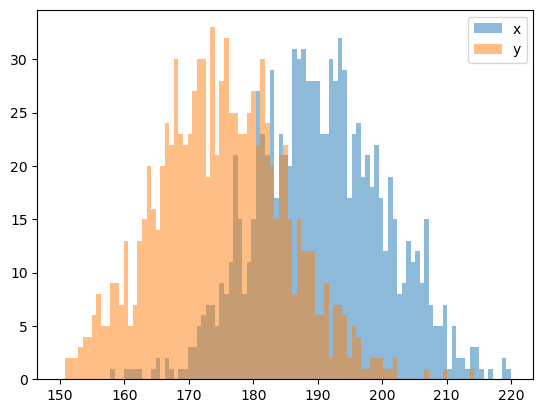

In [35]:
from matplotlib import pyplot
bins = np.linspace(150, 220, 100)

pyplot.hist(bball_samples, bins, alpha=0.5, label='x')
pyplot.hist(other_samples, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

You can clearly see in the histogram the height-distribution and overlap. You can also see that there is an equal number of instances for each class and that the standard deviation is the same.

Now suppose that you are just given the nba_samples and other_samples and told that these are labeled samples for training a Naive Bayes classifier. You also know that they both have a standard deviation of 10cm so we will keep that. In this case the only parameter we are trying to estimate is the mean of each class. So 𝜃=(𝜇𝑛𝑏𝑎,𝜇𝑜𝑡ℎ𝑒𝑟).

Given this data the maximum-likelihood estimate for the means is easily obtained by taking the statistical mean of the samples.

In [36]:
mu_bball = np.mean(bball_samples)
mu_other = np.mean(other_samples)
print(mu_bball, mu_other)

190.53401424928552 174.95131543223874


Now that we have "learned" a model we can use it to predict. Suppose you are given a test height - lets say 183cm. You can calcuate the $P(183/nba)$ and $P(183/other)$ by using the corresponding probability density functions characterized by $\mu_{nba}$ and $\sigma = 10$ and $\mu_{other}$ and $\sigma = 10$. 

In [37]:
from scipy.stats import norm

test_height = 181

p_bball = norm(mu_bball, 10).pdf(test_height)
p_other = norm(mu_other, 10).pdf(test_height)
print(p_bball, p_other)

if (p_bball > p_other): 
    print(str(test_height) + " is more likely a professional basketball player")
else: 
    print(str(test_height) + " is more likely NOT a professional basketball player")


0.025323796182471114 0.033224871192996344
181 is more likely NOT a professional basketball player


## Unsupervised learning 

Now let's make a very simple change to the problem above. Suppose that we know that we have two classes and we have heights. We also know that the standard deviation for each class is 10cm. However we are not given the labels of the heights but just a dataset of heights. 

In [38]:
heights = np.hstack([bball_samples,other_samples])
np.random.shuffle(heights)
print(heights)

[183.25779348 166.95106925 199.62750884 ... 195.05905986 193.4413794
 175.45981639]


If we know the means of the two classes, we can predict the class of each instance (height)

In [39]:
estimated_bball_samples = [] 
estimated_other_samples = []

for h in heights[:20]: 
    p_bball = norm(mu_bball, 10).pdf(h)
    p_other = norm(mu_other, 10).pdf(h)
    if (p_bball > p_other): 
        print('bball', h) 
    else: 
        print('other', h)

bball 183.25779347707206
other 166.95106924922794
bball 199.6275088362795
bball 189.4955703895145
bball 187.08277775934175
other 163.49455706588833
bball 205.42239628975142
other 181.86652521723863
other 176.55549881153638
other 177.02698911845664
other 169.66429240948463
other 177.63082459926736
other 169.3762095288119
other 163.72589689590777
bball 187.81539181016674
other 170.25697717252567
bball 203.61129219160765
other 179.8861067241242
bball 184.332336695728
other 174.50195421670395


So the idea of the EM-algorithm would be let's start with a reasonable guess of the two means, then predict the heights, the re-estimate the means and keep repeating until convergence. 

In [ ]:
mu_bball = 170 
mu_other = 165 


for i in range(0,20): 
    estimated_bball_samples = [] 
    estimated_other_samples = [] 
    print((i,mu_bball, mu_other))

    for h in heights:  
        # E-step - use current model to estimate values for the hidden variable (class membership)
        p_bball = norm(mu_bball, 10).pdf(h)
        p_other = norm(mu_other, 10).pdf(h)
        if (p_bball > p_other): 
            estimated_bball_samples.append(h)
        else: 
            estimated_other_samples.append(h)
   
    # M-step - using the estimated class values re-caculate the parameters of the model i.e the means 
    mu_bball = np.mean(estimated_bball_samples)
    mu_other = np.mean(estimated_other_samples)
        

(0, 170, 165)
(1, 185.578963340917, 161.94314250629293)
(2, 188.21621662003975, 166.62429638620307)
(3, 189.97027789969755, 169.05099263505087)
(4, 191.00096489821175, 170.30347101989184)
(5, 191.65572670540232, 171.07128821893536)
(6, 192.11653003800765, 171.58232369135806)
(7, 192.5188718023523, 172.00217303721027)
(8, 192.79631610824157, 172.27866046032432)
(9, 192.9728514261467, 172.45091243841435)
(10, 193.076897915669, 172.55210531406644)
(11, 193.13957653616455, 172.61260379104624)
(12, 193.2025456312121, 172.6728482996125)
(13, 193.22363369620817, 172.69284259837065)
(14, 193.24466663248413, 172.71289382364347)
(15, 193.2551875178223, 172.72291666418914)
(16, 193.2551875178223, 172.72291666418914)
(17, 193.2551875178223, 172.72291666418914)
(18, 193.2551875178223, 172.72291666418914)
(19, 193.2551875178223, 172.72291666418914)


This is a simple example of the EM-algorithm with only one parameter to estimate per class to show the basic principle. In more real-world scenarios the probabilistic model can be much more complex with many parameters. 
In addition the prediction step typically is done using likelihoods and weighted samples rather than simple 
prediction as in this example. Therefore the E-step and M-step tend to be more complicated and have complex update equations but the basic principle is the same. 


**Advanced**: A great tutorial article on EM is: 

Bilmes JA. A gentle tutorial of the EM algorithm and its application to parameter estimation for Gaussian mixture and hidden Markov models. International Computer Science Institute. 1998 Apr 21;4(510):126.


http://www.leap.ee.iisc.ac.in/sriram/teaching/MLSP_18/refs/GMM_Bilmes.pdf

In [ ]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()
# We have 1797 instances of digits stored as 8x8=64 pixel images. These images are directly used as features. 
print(digits.data.shape)
# 
print(digits.data) 
# the 10th instance 
print(digits.data[10])

In [ ]:
# we can use classifier to train a model for predicting the digit 
# of an 8 by 8 image 

from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

# as a simple example we train using all the data except the last image 
clf.fit(digits.data[:-1], digits.target[:-1]) 

In [ ]:
# we can predict the last instance and the result is the number 8 
print(clf.predict(digits.data[-1:]))
# predicit instance number gives as the number 1 as the prediction 
print(clf.predict([digits.data[1]]))

In [ ]:
import matplotlib.pyplot as plt
%pylab inline

plt.imshow(digits.images[-1:][0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.figure()
plt.imshow(digits.images[1:][0], cmap=plt.cm.gray_r, interpolation='nearest')

In [ ]:
import glob
import librosa
import numpy as np

fnames = glob.glob("/home/gtzan/data/sound/genres44k/*/*.wav")

genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'rock', 'blues', 'reggae', 'pop', 'metal']

# allocate matrix for audio features and target 
audio_features = np.zeros((len(fnames), 40))
target = np.zeros(len(fnames))

# compute the features 
for (i,fname) in enumerate(fnames): 
    print("Processing %d %s" % (i, fname))
    for (label,genre) in enumerate(genres): 
        if genre in fname: 
            audio, srate = librosa.load(fname)
            mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate)
            mean_mfcc = np.mean(mfcc_matrix,axis=1)
            std_mfcc = np.std(mfcc_matrix, axis=1)
            audio_fvec = np.hstack([mean_mfcc, std_mfcc])
            audio_features[i] = audio_fvec
            target[i] = label

print(audio_features.shape)

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import cross_val_predict

clf = svm.SVC(gamma='scale', kernel='linear')
clf.fit(audio_features, target)
predicted = cross_val_predict(clf, audio_features, target, cv=10)

print("Confusion matrix:\n%s" % metrics.confusion_matrix(target, predicted))
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.accuracy_score(target, predicted)))

In [ ]:
# perform 10-fold cross-validation to calculate accuracy and confusion matrix 
predicted = cross_val_predict(clf, audio_features, target, cv=10)

In [ ]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(target, predicted))
print("\nClassification accuracy:%s\n"
      % (metrics.accuracy_score(target, predicted)))

In [ ]:
import random 
i = random.randint(0, 1000)
predicted_label = int(clf.predict([audio_features[i]]))
print("Prediction for %d %s is %s"% (i, fnames[i], genres[predicted_label]))

|Before ending this notebook I would like to mention how impressive it is that with a few lines of Python code and the right libraries we were able to do a full music genre classification system. Twenty years ago building such a system required many lines of C++ code and formed a large part of my PhD thesis which was completed in 2002. The journal article describing this work called "Musical Genre Classification of Audio Signal" is considered a classic paper in MIR.